## Demo for More Advanced Interferometry Simulation and Custom TDI Combination

In [1]:
# limit the thread used by numpy for better parallelization 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import * 

# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Set logging and multiprocessing

run this cell only ONCE

In [3]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [4]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 32


## 1. More advanced simulations

### 1.1 vary noise amplitudes for different MOSAs 
Besides directly running the ``Interferometer.SimulateInterferometers()`` function, we can also break down the entire simulation into several steps, which should be executed in the following order: 
- simulate the basic instrumental noise by ``Interferometer.SimulateBasicNoises()``;
- calculate the light travel times and simulate clock deviations by ``Interferometer.SimulateRangeAndClock()``; 
- calculate the single-arm response of the GWs (if present) by ``Interferometer.SimulateGW()``; 
- combine the basic instrumental noises and GW responses into laser interferometric measurements by ``Interferometer.SimulateMeasurements()``.

Triangle is featured by its high flexiblity in simulation. 
In terms of the instrumental noises, each component of the basic instrumental noises can be modified after running ``Interferometer.SimulateBasicNoises()``, either by adjusting its amplitude, or replacing it with your own noise data. 

<details>
<summary>What can I modify?</summary>

>'acc_noise', 'ro_sci_c_noise', 'ro_sci_sb_noise', 'ro_ref_c_noise', 'ro_ref_sb_noise', 'ro_tm_c_noise', 'laser_noise', 'ob_noise', 'clock_noise', 'bl_noise', 'ranging_noise', 'op_sci_local_noise', 'op_sci_distant_noise', 'op_ref_local_noise', 'op_ref_adjacent_noise', 'op_tm_local_noise', 'op_tm_adjacent_noise', 'modulation_noise'. 
Note that the switches of the noises you want to modify should be set to True. 

>We divide instrumental noises into different types mainly according to the way they enter the laser interferometric measurements. 
The meanings and default units of these alias are shown in the table below: 

<img src="../Figures/noise_types.png" alt="Drawing" style="width: 800px;" align="center">

>where "ifo" stands for the name of interferometer, and unit "optical path derivative" is equivalent to "fractional frequency unit", which is more frequently used in the context of space-based GW detection.  

</details>

For example, in practical detection, the noise levels on the 6 MOSAs might be unequal. 
In this section, we simulate this scenario by multiplying the readout noise of ${\rm ISI}_{c, ij}$ on each MOSA with a random factor. 



In [5]:
fsample = 10
data_time = 100000
size = int(data_time * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=True,
    ro_noise=True, 
    laser_noise=False, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=False, 
    )

# Step 1: 
ifo.SimulateBasicNoise()

# ** modify the amplitudes of ISI_{c,ij} readout noises ** 
for key in MOSA_labels:
    ifo.BasicNoise['ro_sci_c_noise'][key] *= np.random.uniform(1.5, 2.5)  

# Step 2:
ifo.SimulateRangeAndClock()

# Step 3: 
if ifo.gw_flag:
    ifo.SimulateGW()
    
# Step 4: 
ifo.SimulateMeasurements()

# output and synchronize to TCB 
m = ifo.OutputMeasurements(mode='decomposed')
m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

# TDI combination 
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 1000000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interfero

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

#### plot the ASD of TDI 
The results are different from the "nominal" noise models due to the aforementioned modification. 

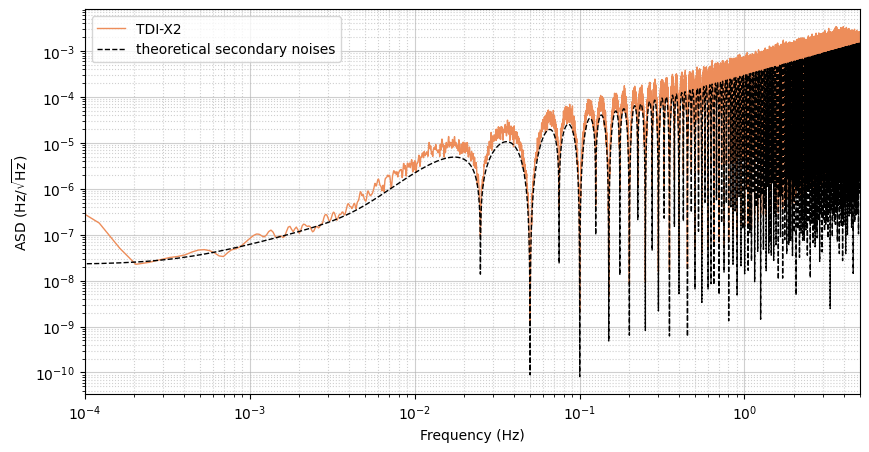

In [6]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 4 # this time we calculate the averaged PSD to show the spectral shape more clearly 
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))

f, xf = PSD_window(tdi.measurements['X2'][drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='TDI-X2')

arms = dict()
arm_idx = int(len(m1['ltt']['12']) / 2.)
for k, v in m1['ltt'].items():
    arms[k] = v[arm_idx]
PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms) 
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', linewidth=1, label = 'theoretical secondary noises') # theoetidal noise PSD based on the "nominal" noise amplitudes 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlim(1e-4, 5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')
plt.legend(loc='upper left')


### 1.2 Glitch injection 
It is predicted that glitches might occur in the optical metrology systems or test-masses [Ref: [PhysRevD.99.024019](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.99.024019)]. 
In this section, we simulate a glitch-only data. A "LPF legacy" glitch is injected to test-mass 12. 

In [7]:
fsample = 10 
data_time = 100000
size = int(data_time * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=True, # turn the acceleration noise on in order to inject glitch.  
    ro_noise=False, 
    laser_noise=False, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=False, 
    )

ifo.SimulateBasicNoise()
ifo.SimulateRangeAndClock()

# add glitch to the acceleration noise 
TM_idx = "12" # the index of TM where glitch happens 
glitch = Glitch(fsample=fsample)
glitch_simulation_time = ifo.proper_time[TM_idx[0]] # generate glitch according to the proper time of spacecraft 1 
glitch_injection_time = 30000. # set injection time 
short_glitch_acc = glitch.LPF_legacy_glitch_model(t=glitch_simulation_time, t0=glitch_injection_time, **glitch.short_glitch_kwargs) # generate glitch in the acceleration unit 
short_glitch_ffd = glitch.acc2ffd(short_glitch_acc) # convert to the fractional frequency difference unit, which is the default unit of BasicNoise["acc_noise"]
for key in MOSA_labels: 
    ifo.BasicNoise['acc_noise'][key] *= 0. # clean the original acceleration noises since we want to simulate a glitch-only data 
ifo.BasicNoise['acc_noise'][TM_idx] = short_glitch_ffd # inject glitch 

if ifo.gw_flag:
    ifo.SimulateGW()
ifo.SimulateMeasurements()
m = ifo.OutputMeasurements(mode='decomposed')
m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 1000000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating locked sources.
INFO:Triangle.Interferom

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

#### visualize glitch in the TDI channel 

Text(0, 0.5, 'Glitch in TDI X2')

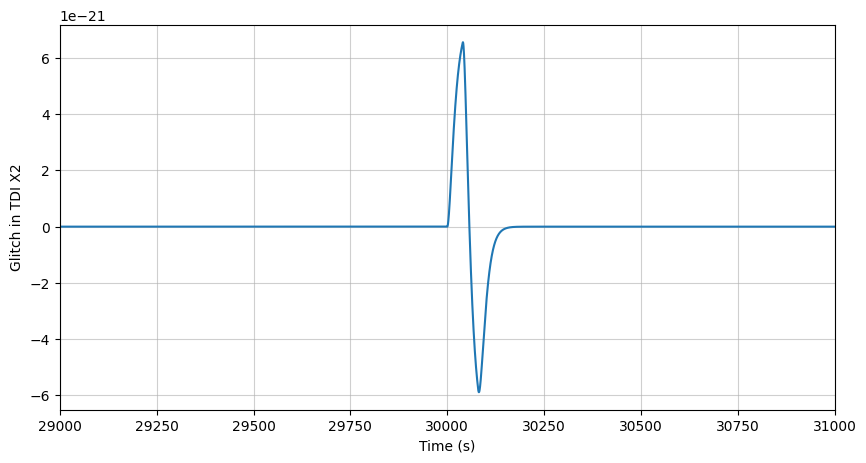

In [8]:
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))

plt.plot(tdi.measurements['time']['1'][drop_points:-drop_points], tdi.measurements['X2'][drop_points:-drop_points] / F_LASER) # convert TDI data to the fractional frequency difference unit

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlim(glitch_injection_time - 1000, glitch_injection_time+1000)

plt.xlabel('Time (s)')
plt.ylabel('Glitch in TDI X2')

## 2. Custom TDI combinations 
The high flexibility of Triangle is also manifested by its support for custom TDI combinations, which can be constructed in 4 ways: 
- by channel name, only valid for "X_1", "X_2", "alpha_1", "alpha_2"; 
- by a faster implementation of the Michelson channels;
- by strings specifying the synthesized optical paths, e.g. ['121313121', '131212131'] stands for the "X_2" channel, the 1st string being the path with plus sign, and the 2nd being the path with minus sign (paths of other channels can be found at e.g. [PhD Thesis of M. Otto](https://repo.uni-hannover.de/handle/123456789/8598?locale-attribute=en));
- by strings specifying the $\boldsymbol{\rm P}_{ij}$ operators so that ${\rm TDI} = \sum_{ij} \boldsymbol{\rm P}_{ij} \eta_{ij}$. This method is the slowest, but can be applied to the widest range of TDI channels. e.g. For the 2nd-generation Michelson X channel, the $P_{ij}$ operators are: 
\begin{align}
    \textbf{P}_{12} &= 1 - \bm{\rm D}_{131} - \bm{\rm D}_{13121} + \bm{\rm D}_{1213131}, \nonumber \\ 
    \textbf{P}_{23} &= 0, \nonumber \\ 
    \textbf{P}_{31} &= -\bm{\rm D}_{13} + \bm{\rm D}_{1213} + \bm{\rm D}_{121313} - \bm{\rm D}_{13121213}, \nonumber \\ 
    \textbf{P}_{21} &= \bm{\rm D}_{12} - \bm{\rm D}_{1312} - \bm{\rm D}_{131212} + \bm{\rm D}_{12131312}, \nonumber \\ 
    \textbf{P}_{32} &= 0, \nonumber \\ 
    \textbf{P}_{13} &= -1 + \bm{\rm D}_{121} + \bm{\rm D}_{12131} - \bm{\rm D}_{1312121}.  \nonumber
\end{align}
which can be specified by the following strings: 

In [12]:
# "ij" represents the delay operator D_{ij}, while "-ij" stands for the corresponding "advance" operator A_{ij}
X2_string = {
    "12": [(1., []), (-1., ["13", "31"]), (-1., ["13", "31", "12", "21"]), (1., ["12", "21", "13", "31", "13", "31"])], 
    "23": [], 
    "31": [(-1., ["13"]), (1., ["12", "21", "13"]), (1., ["12", "21", "13", "31", "13"]), (-1., ["13", "31", "12", "21", "12", "21", "13"])], 
    "21": [(1., ["12"]), (-1., ["13", "31", "12"]), (-1., ["13", "31", "12", "21", "12"]), (1., ["12", "21", "13", "31", "13", "31", "12"])], 
    "32": [], 
    "13": [(-1., []), (1., ["12", "21"]), (1., ["12", "21", "13", "31"]), (-1., ["13", "31", "12", "21", "12", "21"])], 
}

The index permutation rule $(1 \rightarrow 2, 2 \rightarrow 3, 3 \rightarrow 1)$ is a useful tool for deriving the string of Y channel from that of X channel, and Z channel from Y channel. 

In [13]:
Y2_string = TDIStringManipulation.TDIStringCyc(X2_string)
Z2_string = TDIStringManipulation.TDIStringCyc(Y2_string)
Y2_string, Z2_string

({'23': [(1.0, []),
   (-1.0, ['21', '12']),
   (-1.0, ['21', '12', '23', '32']),
   (1.0, ['23', '32', '21', '12', '21', '12'])],
  '31': [],
  '12': [(-1.0, ['21']),
   (1.0, ['23', '32', '21']),
   (1.0, ['23', '32', '21', '12', '21']),
   (-1.0, ['21', '12', '23', '32', '23', '32', '21'])],
  '32': [(1.0, ['23']),
   (-1.0, ['21', '12', '23']),
   (-1.0, ['21', '12', '23', '32', '23']),
   (1.0, ['23', '32', '21', '12', '21', '12', '23'])],
  '13': [],
  '21': [(-1.0, []),
   (1.0, ['23', '32']),
   (1.0, ['23', '32', '21', '12']),
   (-1.0, ['21', '12', '23', '32', '23', '32'])]},
 {'31': [(1.0, []),
   (-1.0, ['32', '23']),
   (-1.0, ['32', '23', '31', '13']),
   (1.0, ['31', '13', '32', '23', '32', '23'])],
  '12': [],
  '23': [(-1.0, ['32']),
   (1.0, ['31', '13', '32']),
   (1.0, ['31', '13', '32', '23', '32']),
   (-1.0, ['32', '23', '31', '13', '31', '13', '32'])],
  '13': [(1.0, ['31']),
   (-1.0, ['32', '23', '31']),
   (-1.0, ['32', '23', '31', '13', '31']),
   (1.0, ['31

In [15]:
A2_string, E2_string, T2_string = TDIStringManipulation.AETStringsfromXString(X2_string)
A2_string, E2_string, T2_string

({'12': [(-0.7071067811865475, []),
   (0.7071067811865475, ['13', '31']),
   (0.7071067811865475, ['13', '31', '12', '21']),
   (-0.7071067811865475, ['12', '21', '13', '31', '13', '31'])],
  '13': [(0.7071067811865475, []),
   (-0.7071067811865475, ['12', '21']),
   (-0.7071067811865475, ['12', '21', '13', '31']),
   (0.7071067811865475, ['13', '31', '12', '21', '12', '21']),
   (0.7071067811865475, ['31']),
   (-0.7071067811865475, ['32', '23', '31']),
   (-0.7071067811865475, ['32', '23', '31', '13', '31']),
   (0.7071067811865475, ['31', '13', '32', '23', '32', '23', '31'])],
  '23': [(-0.7071067811865475, ['32']),
   (0.7071067811865475, ['31', '13', '32']),
   (0.7071067811865475, ['31', '13', '32', '23', '32']),
   (-0.7071067811865475, ['32', '23', '31', '13', '31', '13', '32'])],
  '21': [(-0.7071067811865475, ['12']),
   (0.7071067811865475, ['13', '31', '12']),
   (0.7071067811865475, ['13', '31', '12', '21', '12']),
   (-0.7071067811865475, ['12', '21', '13', '31', '13', '

#### simulate interferometer data 

In [16]:
fsample = 10
data_time = 100000 
size = int(data_time * fsample)
interp_order = 31

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=False, 
    ob_noise=False,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 1000000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generat

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### calculate X2 channel in 4 ways and compare

In [17]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=31)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)

# 1)
tdi.CalculateBasicTDI(channel='X2', doppler=True)
X2_method1 = tdi.measurements['X2'].copy()

# 2)
tdi.FastMichelson(doppler=True, channel='X') # channel can be 'X', 'XYZ' or 'AET'
X2_method2 = tdi.measurements['X2'].copy()

# 3) 
tdi.CalculateBasicTDI(channel=['121313121', '131212131'], doppler=True, channel_name='X2')
X2_method3 = tdi.measurements['X2'].copy()

# 4) 
X2_method4 = tdi.CalculateTDIFromPStrings(X2_string, doppler=True)

INFO:Triangle.TDI:TDI channel X2 calculated.
INFO:Triangle.TDI:TDI channel X2 calculated.


#### illustrate the consistency among methods 

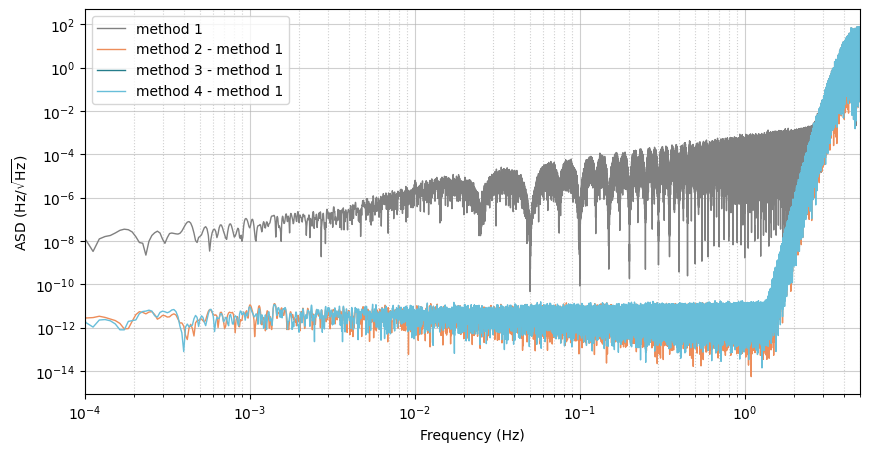

In [18]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))

f, xf = PSD_window(X2_method1[drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color="grey", linewidth=1, label='method 1')

f, xf = PSD_window((X2_method2 - X2_method1)[drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='method 2 - method 1')

f, xf = PSD_window((X2_method3 - X2_method1)[drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, linewidth=1, label='method 3 - method 1') # equal to 0 hence not shown in the figure 

f, xf = PSD_window((X2_method4 - X2_method1)[drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict) 
plt.loglog(f, np.sqrt(xf), color=BLUE, linewidth=1, label='method 4 - method 1') 

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.xlim(1e-4, 5)

plt.legend(loc='upper left')
